# One-dimensional advection equation

We want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

The independen variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input.

In [ ]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# imports
import math
import numpy as np 
import matplotlib.pyplot as plt 

import torch
cuda = True
device = "cuda" if torch.cuda.is_available() and cuda else "cpu"

## Define PDE

First we define our PDE and set the values for training.

In [ ]:
# imports
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco

# define our PDE
class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None):
        super().__init__(inputs, outputs)
    # the loss of our NN is the PDE !
    def computePDELoss(self, grads, inputs, params): 
        dpdt, dpdx = grads['p']['t'], grads['p']['x']
        u = inputs['u']
        return dpdt + u*dpdx

# instanciate pde with keys for inputs/outputs
pde = MyPDE(inputs=['x', 't', 'u'], outputs=['p'])

# define input values for training
x_t = np.linspace(0,1,30)
t_t = np.linspace(0,1,20)
u_t = np.linspace(0,1,10)
pde.setValues({'x': x_t, 't': t_t, 'u': u_t})

# periodic b.c for the space dimension
x1, x2 = np.array([0]), np.array([1])
boco = PeriodicBoco('boco', {'x': x1, 't': t_t, 'u': u_t}, {'x': x2, 't': t_t, 'u': u_t})
pde.addBoco(boco)

# initial condition (dirichlet for temporal dimension)
p00, p0 = np.sin(2.*math.pi*x_t), np.array([])
for i in u_t:
    p0 = np.concatenate((p0,p00)) # one for each value of 'u', keeping the order (x, t, u)
boco = DirichletBoco('initial_condition', {'x': x_t, 't': np.array([0]), 'u': u_t}, {'p': p0})
pde.addBoco(boco)

# define input values for validation
x_v = np.linspace(0,1,25)
t_v = np.linspace(0,1,15)
u_v = np.linspace(0,1,5)
pde.setValues({'x': x_v, 't': t_v, 'u': u_v}, train=False)

Now we define a topology for our solution and set the training parameters. Then we can find a solution for our PDE.

In [ ]:
# define solution topology
topo = {'layers': 5, 'neurons': 512, 'activations': 'relu'}
pde.buildSolution(topo)

# set optimization parameters
pde.compile(lr=0.0001, epochs=20, batch_size=32)


In [ ]:
# find the solution
hist = pde.solve(device, 'adv1d_best.pth') 

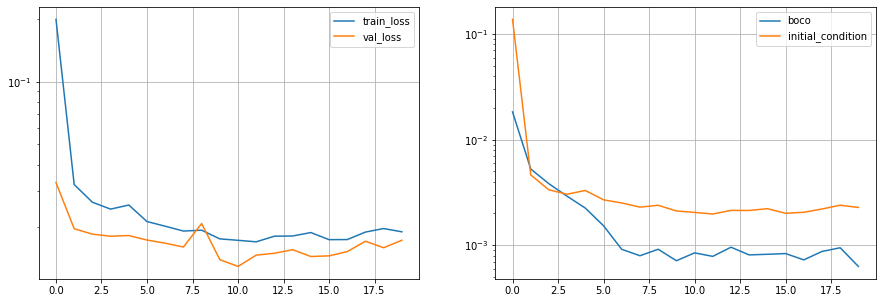

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.plot(hist['val_loss'], label="val_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

Finally, we can evaluate our solution.

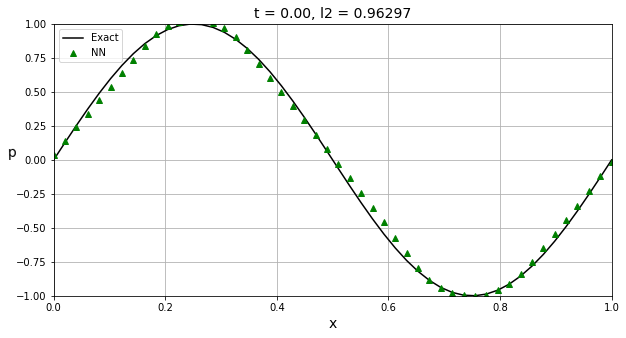

In [ ]:
# evaluate the solution
pde.load_state_dict('adv1d_best.pth')
x = np.linspace(0,1,50)
t = np.linspace(0,1,50)
u = np.array([0.655])
p, p0, l2 = [], [], []
for _t in t:
    _p0 = np.sin(2.*math.pi*(x-u*_t))
    _p = pde.eval({'x': x, 't': np.array([_t]), 'u': u}, device)
    _l2 = np.mean((_p - _p0)**2)
    p.append(_p)
    p0.append(_p0)
    l2.append(_l2)
    
from matplotlib import animation, rc
rc('animation', html='html5')

def plot(x, p, p0, t, l2):
    ax.clear()
    tit = ax.set_title(f"t = {t:.2f}, l2 = {l2:.5f}", fontsize=14)
    ax.plot(x, p0, "-k", label="Exact")
    ax.plot(x, p, "g^", label="NN")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper left")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1, 1])
    return [tit]

def get_anim(fig, ax, x, p, p0, t, l2):
    def anim(i):
        return plot(x, p[i], p0[i], t[i], l2[i])
    return anim

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, x, p, p0, t, l2)
anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)

In [ ]:
anim